Epoch 1/15 | Train Loss: 0.0003 | Test Loss: 0.0007 | ETA: 09:26


Epoch 2/15 | Train Loss: 0.0004 | Test Loss: 0.0007 | ETA: 08:36


Epoch 3/15 | Train Loss: 0.0009 | Test Loss: 0.0007 | ETA: 07:40


Epoch 4/15 | Train Loss: 0.0007 | Test Loss: 0.0007 | ETA: 06:55


Epoch 5/15 | Train Loss: 0.0004 | Test Loss: 0.0007 | ETA: 06:13


Epoch 6/15 | Train Loss: 0.0008 | Test Loss: 0.0007 | ETA: 05:33


Epoch 7/15 | Train Loss: 0.0010 | Test Loss: 0.0007 | ETA: 04:55


Epoch 8/15 | Train Loss: 0.0007 | Test Loss: 0.0007 | ETA: 04:20


Epoch 9/15 | Train Loss: 0.0004 | Test Loss: 0.0006 | ETA: 03:43


Epoch 10/15 | Train Loss: 0.0003 | Test Loss: 0.0007 | ETA: 03:05


Epoch 11/15 | Train Loss: 0.0003 | Test Loss: 0.0005 | ETA: 02:28


Epoch 12/15 | Train Loss: 0.0001 | Test Loss: 0.0003 | ETA: 01:51


Epoch 13/15 | Train Loss: 0.0001 | Test Loss: 0.0001 | ETA: 01:14


Epoch 14/15 | Train Loss: 0.0001 | Test Loss: 0.0000 | ETA: 00:37


Epoch 15/15 | Train Loss: 0.0001 | Test Loss: 0.0000 | ETA: 00:00


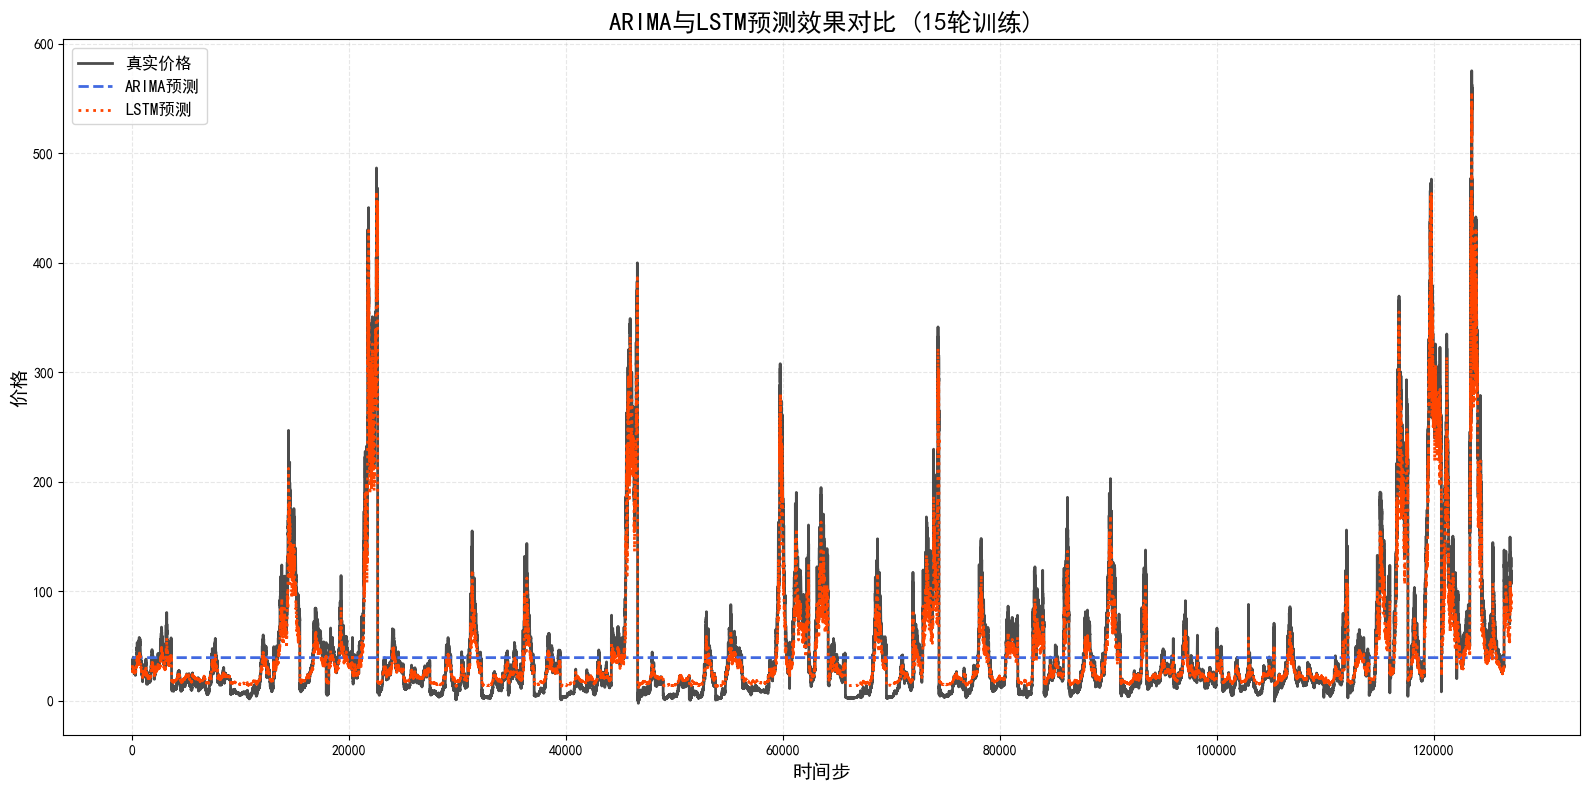


性能对比：
ARIMA MAPE: 196.66%
LSTM MAPE: 55.33%


In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文
matplotlib.rcParams['axes.unicode_minus'] = False    # 正常显示负号

# 1. 数据预处理
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='utf-8')  # 如有乱码可改为'gbk'
    col_map = {'开盘':'Open', '最高':'High', '最低':'Low', '收盘':'Close', '成交量':'Volume'}
    return df.rename(columns=col_map).ffill().bfill()

# 2. 时间序列数据集
class StockDataset(Dataset):
    def __init__(self, data, look_back=30):
        self.data = torch.FloatTensor(data)
        self.look_back = look_back
        
    def __len__(self):
        return len(self.data) - self.look_back - 1
    
    def __getitem__(self, idx):
        # 兼容单列和多列数据
        X = self.data[idx:idx+self.look_back]
        if self.data.shape[1] == 1:
            y = self.data[idx+self.look_back, 0]
        else:
            y = self.data[idx+self.look_back, 3]  # Close价格位置
        return X, y

# 3. LSTM模型
class LiteLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_size=32, num_layers=2):  # 修改input_dim为1，hidden_size=32，num_layers=2
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :]).squeeze(-1)

# 4. ARIMA模型训练与预测
def arima_predict(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # ARIMA模型训练 (自动选择最优参数)
    model = ARIMA(train_data, order=(5,1,0))  # 可根据数据调整p,d,q
    model_fit = model.fit()
    
    # 预测
    predictions = model_fit.forecast(steps=len(test_data))
    return predictions, test_data

# 5. LSTM训练函数（30轮次）
def train_lstm(model, train_loader, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    for epoch in range(15):  # 训练轮数由30降为15
        model.train()
        train_loss = 0
        batch_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}/15', leave=False)
        
        for X_batch, y_batch in batch_iter:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # 验证阶段
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss += criterion(outputs, y_batch).item()
        
        # 计算剩余时间
        elapsed = time.time() - start_time
        avg_time = elapsed / (epoch + 1)
        remaining = avg_time * (15 - epoch - 1)
        mins, secs = divmod(remaining, 60)
        
        print(f'Epoch {epoch+1}/15 | '
              f'Train Loss: {train_loss/len(train_loader):.4f} | '
              f'Test Loss: {test_loss/len(test_loader):.4f} | '
              f'ETA: {int(mins):02d}:{int(secs):02d}')

# 6. 主流程
if __name__ == "__main__":
    # 数据加载与处理
    df = load_data('train.csv')
    close_prices = df['Close'].values.reshape(-1, 1)
    
    # 标准化
    scaler = MinMaxScaler(feature_range=(0.001, 1))
    scaled_data = scaler.fit_transform(close_prices)
    
    # ARIMA模型预测
    arima_pred, arima_test = arima_predict(scaled_data)
    arima_pred = scaler.inverse_transform(arima_pred.reshape(-1, 1)).flatten()
    arima_test = scaler.inverse_transform(arima_test.reshape(-1, 1)).flatten()
    
    # LSTM数据准备
    look_back = 30
    train_size = int(len(scaled_data) * 0.8)
    train_data = StockDataset(scaled_data[:train_size], look_back)
    test_data = StockDataset(scaled_data[train_size:], look_back)
    
    # DataLoader
    batch_size = 32
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    
    # LSTM模型训练
    model = LiteLSTM(input_dim=1)  # 仅使用Close价格
    train_lstm(model, train_loader, test_loader)
    
    # LSTM预测
    def predict(model, data_loader, scaler):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()
        preds = []
        with torch.no_grad():
            for X_batch, _ in data_loader:
                X_batch = X_batch.to(device)
                outputs = model(X_batch)
                if outputs.dim() > 1:
                    outputs = outputs.squeeze(-1)
                preds.append(outputs.cpu().numpy())
        preds = np.concatenate(preds)
        # 还原为原始价格，兼容单列和多列
        dummy = np.zeros((len(preds), scaler.n_features_in_))
        if scaler.n_features_in_ == 1:
            dummy[:, 0] = preds
            inv = scaler.inverse_transform(dummy)
            return inv[:, 0]
        else:
            dummy[:, 3] = preds  # Close列
            inv = scaler.inverse_transform(dummy)
            return inv[:, 3]

    lstm_pred = predict(model, test_loader, scaler)
    # 仅有一列时，取第0列，并保证长度一致
    lstm_test_full = scaler.inverse_transform(scaled_data[train_size+look_back:])[:, 0]
    lstm_test = lstm_test_full[:len(lstm_pred)]
    
    # 对比可视化
    plt.figure(figsize=(16,8))
    x = np.arange(len(lstm_pred))
    plt.plot(x, lstm_test, label='真实价格', color='black', linewidth=2, alpha=0.7)
    plt.plot(x, arima_pred[:len(x)], label='ARIMA预测', color='royalblue', linestyle='--', linewidth=2)
    plt.plot(x, lstm_pred, label='LSTM预测', color='orangered', linestyle=':', linewidth=2)
    plt.title('ARIMA与LSTM预测效果对比 (15轮训练)', fontsize=18)
    plt.xlabel('时间步', fontsize=14)
    plt.ylabel('价格', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 计算评价指标
    def mape(y_true, y_pred):  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n性能对比：")
    print(f"ARIMA MAPE: {mape(arima_test, arima_pred):.2f}%")
    print(f"LSTM MAPE: {mape(lstm_test, lstm_pred):.2f}%")